# Frogger Agents

In [ ]:
import ale_py, cv2, os, random
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, deque
from gymnasium.wrappers import RecordVideo

In [2]:
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.1_3/bin/ffmpeg"  #Path to FFMPEG for recording

## Tabular Q-learning

In [5]:
class QLearningAgent:
    def __init__(self, actionSpace, lr=0.01, discount = 0.95, epsilonMax =1.0, epsilonDecay=0.999, epsilonMin=0.0):
        self.actionSpace = actionSpace
        self.qTable = defaultdict(lambda: np.zeros(self.actionSpace))  # Hash-based for less memory usage
        self.lr = lr
        self.discount = discount
        self.epsilon = epsilonMax
        self.epsilonDecay = epsilonMax / 200000  #Epsilon decays equivalently with number of episodes
        self.epsilonMin = epsilonMin

    def action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actionSpace)  # Explore
        else:
            return int(np.argmax(self.qTable[state]))  # Exploit

    def update(self, state, action, reward, nextState, done):
        bestAction = np.max(self.qTable[nextState]) * (not done)  # Retrieve best action
        target = reward + self.discount * bestAction
        self.qTable[state][action] += self.lr * (target - self.qTable[state][action])  # Update Q-table

        # Decay epsilon
        if done:            
            self.epsilon = max(self.epsilonMin, self.epsilon - self.epsilonDecay)

In [4]:
stateCache = {}  # Prevents repreocessing of the same state

def preprocessState(state):
    """Convert the raw state into a reduced, discrete state."""
    if id(state) not in stateCache:
        # Convert to grayscale
        state = cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)
        # Resize to smaller dimensions
        state = cv2.resize(state, (84, 84), interpolation=cv2.INTER_AREA)
        # Normalize and flatten
        state = state / 255.0  # Scale pixel values to [0, 1] (Normalize)
        stateCache[id(state)] = state.flatten()  # Flatten to 1D
    return tuple(stateCache[id(state)])  #Convert to tuple

In [6]:
# Create Frogger environment
gym.register_envs(ale_py)
env = gym.make("ALE/Frogger-v5", render_mode='rgb_array')  #rgb_array for balance between recording and memory/speed
actionSpace = env.action_space.n

agent = QLearningAgent(actionSpace)

episodes = 200000
recordingPeriod = 20000
episodeRewards = []
trainingErrors = []

# Records a video of implementation every recordingPeriod
env = RecordVideo(env, video_folder="frogger-agent", name_prefix=f"eval_{episodes}",
                  episode_trigger=lambda x: x % recordingPeriod == 0)

for episode in range(episodes):
    state, _ = env.reset()
    state = preprocessState(state)
    totalReward = 0
    errors = []
    done = False

    while not done:
        action = agent.action(state)
        nextState, reward, done, truncated, _ = env.step(action)
        nextState = preprocessState(nextState)

        # Error calculation
        currentQ = agent.qTable[tuple(state)][action]
        agent.update(state, action, reward, nextState, done)
        newQ = agent.qTable[tuple(state)][action]
        errors.append(abs(newQ - currentQ))

        totalReward += reward
        state = nextState

    
    # Track metrics
    episodeRewards.append(totalReward)
    trainingErrors.append(np.mean(errors))  # Average TD error for the episode

    if episode % 10000 == 0:
        print(f"Episode {episode}/{episodes}, Total Reward: {totalReward}, Epsilon: {agent.epsilon:.2f}")

env.close()

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/powellt/Documents/DSCI-6612/TermProject/Frogger/frogger-agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 0/200000, Total Reward: 9.0, Epsilon: 1.00
Episode 10000/200000, Total Reward: 8.0, Epsilon: 0.95
Episode 20000/200000, Total Reward: 9.0, Epsilon: 0.90
Episode 30000/200000, Total Reward: 11.0, Epsilon: 0.85
Episode 40000/200000, Total Reward: 10.0, Epsilon: 0.80
Episode 50000/200000, Total Reward: 10.0, Epsilon: 0.75
Episode 60000/200000, Total Reward: 10.0, Epsilon: 0.70
Episode 70000/200000, Total Reward: 9.0, Epsilon: 0.65
Episode 80000/200000, Total Reward: 10.0, Epsilon: 0.60
Episode 90000/200000, Total Reward: 16.0, Epsilon: 0.55
Episode 100000/200000, Total Reward: 10.0, Epsilon: 0.50
Episode 110000/200000, Total Reward: 19.0, Epsilon: 0.45
Episode 120000/200000, Total Reward: 9.0, Epsilon: 0.40
Episode 130000/200000, Total Reward: 10.0, Epsilon: 0.35
Episode 140000/200000, Total Reward: 11.0, Epsilon: 0.30
Episode 150000/200000, Total Reward: 9.0, Epsilon: 0.25
Episode 160000/200000, Total Reward: 9.0, Epsilon: 0.20
Episode 170000/200000, Total Reward: 13.0, Epsilon: 

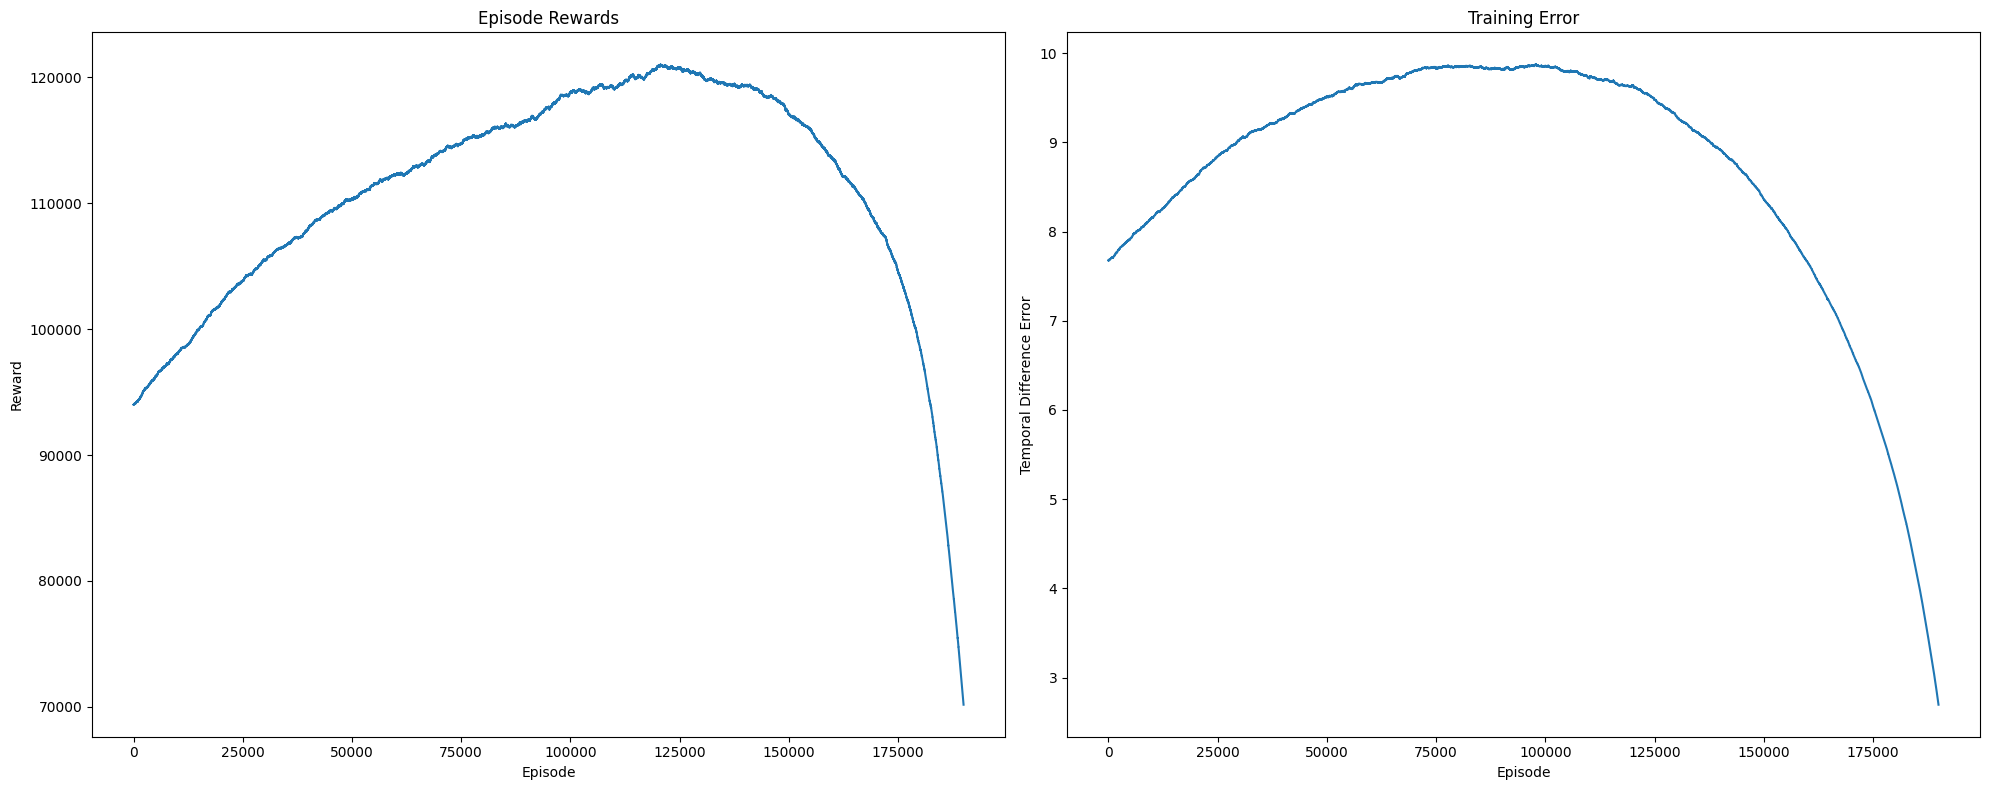

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Compute rolling averages
rollingWindow = 10000
rewards = np.convolve(episodeRewards, np.ones(rollingWindow), mode='valid')
errors = np.convolve(trainingErrors, np.ones(rollingWindow), mode='valid')

# Episode Rewards
axs[0].plot(rewards)
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

# Training Errors
axs[1].plot(errors)
axs[1].set_title("Training Error")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Temporal Difference Error")

plt.tight_layout()
plt.show()

env.close()